<a href="https://colab.research.google.com/github/asravankumar/END2.0/blob/master/assignment_3_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the Essentials**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset

**Download Training MNIST Data**

In [192]:
# download training mnist dataset which consists of 60000 labelled images
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor() # converts the images into pytorch tensors
    ])
)

**Data Set Creation**

Create custom MNIST Adder dataset which consists of mnist images + random number as input and the correct image label and sum as output.

The random number is a one-hot encoding vector.

In [161]:
# data set creation
class MNISTAdderDataset(Dataset):
  # Dataset to create mnist custom data for mnist + random number adder.

  def __init__(self, dataset):
    self.mnist_data = dataset
    
  def __getitem__(self, index):
    # returns tuple with following input and output for every image.
    # input : x1 - tensor image
    # input : x2 - one hot vector for random number
    # labelled output : y1 - the image's label number.
    # labelled output : y2 - the sum.

    x1, y1 = self.mnist_data[index]
    x2 = random.randint(0,9)
    y2 = y1 + x2 
    return (x1, F.one_hot(torch.tensor(x2), 10).float(), y1, y2)

  def __len__(self):
    return len(self.mnist_data)

**Data Loader with batch**

In [162]:
mnist_adder_training_data = MNISTAdderDataset(train_set)
mnist_adder_training_data_loader = torch.utils.data.DataLoader(mnist_adder_training_data,
                                               batch_size=100,
                                               shuffle=False,
                                               )

In [163]:
next(iter(mnist_adder_training_data_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

**Visualizing sample data**

label 5
random number hot vector tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
sum 5
torch.Size([1, 28, 28])


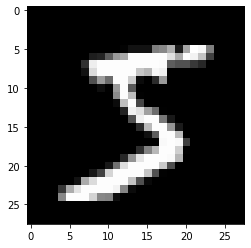

In [164]:
x1, x2, y1, y2 = next(iter(mnist_adder_training_data))
plt.imshow(x1.squeeze(), cmap='gray')
print('label', y1)
print('random number hot vector', x2)
print('sum', y1)
print(x1.shape)


**Network Creation**

In [188]:
import torch.nn as nn
import torch.nn.functional as F

# Network creation

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # input is 28x28 with 1 channel, kernel size is 5x5
        # output of convolution layer is 24x24 i.e (28 - 5 )/ 1 + 1
        # maxpool layer is with kernel size 2 and stride 2
        # output of max pool layer is 12x12 i.e (24 - 2)/2 + 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

        # input is 12x12 with 1 channel, kernel size is 5x5
        # output of convolution layer is 8x8 i.e (12 - 5 )/ 1 + 1
        # maxpool layer is with kernel size 2 and stride 2
        # output of max pool layer is 4x4 i.e (8 - 2)/2 + 1
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        # fully connected layer with input will be 12 * 4 * 4
        # and 50 output features
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=50)
        # another fully connected layer
        self.fc2 = nn.Linear(in_features=50, out_features=40)
        # output layer for image classification
        self.out = nn.Linear(in_features=40, out_features=10)

        # fully connected layer after combining image classification output and random number one-hot vector.
        self.fc3 = nn.Linear(in_features=20, out_features=21)
        #self.fc4 = nn.Linear(in_features=30, out_features=24)

        # final sum output layer. 19 features output. 19 because of one-hot vector for 0 to 19. as sum of 0 - 9 image  with 0 - 9 random numbers.
         self.out2 = nn.Linear(in_features=21, out_features=19)

    def forward(self, t, rand_num_vector):
        # convolution layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # convolution layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # hidden linear layer
        # converting the image to a straight vector.
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # output layer for image classification
        t = self.out(t)
        
        # converting to one hot vector for image predicted value.
        t_vector = F.one_hot(t.argmax(dim=1), num_classes=10)
        #print("t_vector", t_vector)
        #print("rand_num_vector", rand_num_vector)

        # now combining the image output with random number vector for addition.
        combined_vector = torch.cat([t_vector, rand_num_vector], dim=-1)
        #print("combined vector", combined_vector)
        combined_vector = self.fc3(combined_vector)
        combined_vector = F.relu(combined_vector)

        #combined_vector = self.fc4(combined_vector)
        #combined_vector = F.relu(combined_vector)


        # final layer with outputs the sum of the two numbers.
        combined_vector = self.out2(combined_vector)
        combined_vector = F.relu(combined_vector)

        return t, combined_vector

**Network Details**

In [166]:
network = Network()
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=40, bias=True)
  (out): Linear(in_features=40, out_features=10, bias=True)
  (fc3): Linear(in_features=20, out_features=24, bias=True)
  (out2): Linear(in_features=24, out_features=19, bias=True)
)

**Checking the predicted value in the network**

In [189]:
x1, x2, y1, y2 = next(iter(mnist_adder_training_data))
print('y1:', y1)
print('x2:', x2)
print('y2:', y2)

network = Network()
pred_y1, pred_y2 = network(x1.unsqueeze(0), x2.unsqueeze(0))

print('Predicted Image :', pred_y1.argmax(dim=1))
print('Predicted Sum :', pred_y2.argmax(dim=1))


y1: 5
x2: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
y2: 12
Predicted Image : tensor([9])
Predicted Sum : tensor([5])


**Training the Network**

In [190]:
import torch.optim as optim
torch.set_grad_enabled(True) # to enable the gradients.

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.02) # using adam's optimizer with learning rate of 0.02

# to check the number of correct predictions.
def get_num_correct(X, Y):
  return X.argmax(dim=1).eq(Y).sum().item()



for epoch in range(10):

    total_loss = 0
    total_correct_mnist = 0
    total_correct_sum = 0

    for batch in mnist_adder_training_data_loader:
        # for every batch predict using network and backpropagate the loss.
        # x1s : images input
        # x2s : random number one hot vectors.
        # y1s : image labels.
        # y2s : sum.
    
        x1s, x2s, y1s, y2s = batch
        x2s = x2s.squeeze()

        # predictions
        predicted_y1s, predicted_y2s = network(x1s, x2s)

        # calculate the loss for image prediction.
        loss1 = F.cross_entropy(predicted_y1s, y1s)
        # calculate the loss for sum.
        loss2 = F.cross_entropy(predicted_y2s, y2s)
        loss = loss1 + loss2 # total loss.

        optimizer.zero_grad()           
        loss.backward()                 # calculate gradients
        optimizer.step()                # update weights 


        total_loss += loss.item()
        total_correct_mnist += get_num_correct(predicted_y1s, y1s)
        total_correct_sum += get_num_correct(predicted_y2s, y2s)
        #break
    #break
    image_accuracy = (total_correct_mnist/60000.0)*100;
    image_sum = (total_correct_sum/60000.0)*100;

    print(
        "epoch:", epoch,
        "batch_size: ", 100,
        "correct_images_count", total_correct_mnist,
        "correct_sum_count", total_correct_sum,
        "image_accuracy",image_accuracy, 
        "sum_accuracy", image_sum,
        "total_loss", total_loss
    )

epoch: 0 batch_size:  100 correct_images_count 54612 correct_sum_count 38350 image_accuracy 91.02 sum_accuracy 63.916666666666664 total_loss 968.1364297270775
epoch: 1 batch_size:  100 correct_images_count 57231 correct_sum_count 43314 image_accuracy 95.38499999999999 sum_accuracy 72.19 total_loss 692.24047935009
epoch: 2 batch_size:  100 correct_images_count 57431 correct_sum_count 43342 image_accuracy 95.71833333333333 sum_accuracy 72.23666666666666 total_loss 678.8417452573776
epoch: 3 batch_size:  100 correct_images_count 57670 correct_sum_count 43670 image_accuracy 96.11666666666666 sum_accuracy 72.78333333333333 total_loss 660.866904437542
epoch: 4 batch_size:  100 correct_images_count 57632 correct_sum_count 43569 image_accuracy 96.05333333333334 sum_accuracy 72.615 total_loss 666.2280558943748
epoch: 5 batch_size:  100 correct_images_count 57715 correct_sum_count 43771 image_accuracy 96.19166666666666 sum_accuracy 72.95166666666667 total_loss 656.60302901268
epoch: 6 batch_size

**Testing the Network & Model**

Download test MNIST data

In [196]:
# download test mnist data which consists of 10000 images.

test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

# test data loaders
mnist_adder_test_data = MNISTAdderDataset(test_set)
mnist_adder_test_data_loader = torch.utils.data.DataLoader(mnist_adder_test_data,
                                               batch_size=100,
                                               shuffle=False,
                                               )

**Model Accuracy with test data**

In [200]:
total_image_correct = 0
total_sum_correct = 0

for batch in mnist_adder_test_data_loader:
  x1s, x2s, y1s, y2s = batch
  predicted_y1s, predicted_y2s = network(x1s, x2s)
  total_image_correct += get_num_correct(predicted_y1s, y1s)
  total_sum_correct += get_num_correct(predicted_y2s, y2s)

print("total_image_correct", total_image_correct, "image prediction accuracy:", (total_image_correct/10000.0) * 100)
print("total_sum_correct", total_sum_correct, "sum prediction accuracy", (total_sum_correct/10000) * 100)

total_image_correct 9625 image prediction accuracy: 96.25
total_sum_correct 7217 sum prediction accuracy 72.17
